<center><h1>Testing and Documentation Notebook for Cellular Automaton Using Inheritance from NumPy NDArray</h1></center>
This document is for testing/demonstrating a cellular automaton class, CAGrid, which inherits much of its functionality from [NumPy](http://www.numpy.org/) [array objects](https://docs.scipy.org/doc/numpy/reference/arrays.html).  The CAGrid class enables use of the array operations (implemented in C) which should make the execution speed better.  This document assumes the reader is somewhat familiar with NumPy.  It also assumes the user is somewhat familiar with classes and inheritance in Python.  If these concepts are not familiar, the following are good resources to consult.

- Numpy has a [Quick Start Guide](https://docs.scipy.org/doc/numpy/user/quickstart.html).  Especially important to understanding this learning module are the concepts of [array views](https://docs.scipy.org/doc/numpy/user/quickstart.html#view-or-shallow-copy), [NumPy Data types (dtype)](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html), and [NumPy structured arrays](https://docs.scipy.org/doc/numpy/user/basics.rec.html).

- [Jessica Hamrick](http://www.jesshamrick.com/) has a great [Introduction to Classes and Inheritance (in Python)](http://www.jesshamrick.com/2011/05/18/an-introduction-to-classes-and-inheritance-in-python).  This is especially good for those who have not used object oriented programing before.

- The Python Tutorial describes [classes](https://docs.python.org/3/tutorial/classes.html) in Python.  This includes [A First Look](https://docs.python.org/3/tutorial/classes.html#a-first-look-at-classes), a description of [Class and Instance Variables](https://docs.python.org/3/tutorial/classes.html#class-and-instance-variables), and a discussion of [Inheritance](https://docs.python.org/3/tutorial/classes.html#inheritance).

Even for those familiar with NumPy arrays and Python classes/inheritance, the inheritance of NumPy arrays is rather unique.  The document [Subclassing ndarray](https://docs.scipy.org/doc/numpy/user/basics.subclassing.html) should be consulted to understand the inheritance of NumPy.ndarray to form the class CAGrid used in this notebook.

# Results
The video below is a game of life simulation using the code in this module.
<video controls autoplay loop src="GOL_Large_Sim.mp4" />

# Initialization

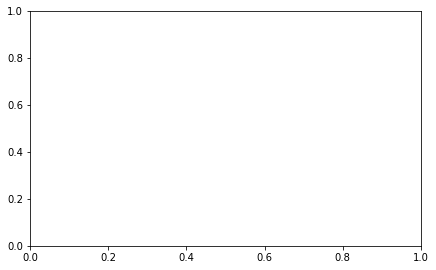

In [3]:
from CellularAutomaton import *
from IPython.display import display
import inspect
from math import *

#for plotting in this notebook.
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
matplotlib.rc('animation', html='html5')
matplotlib.rcParams['image.cmap'] = 'jet'   #Set matshow colors to v 1.0 style
#set the plot aspect ratio and setup a default figure to use.
goldenratio=1/2*(1+sqrt(5)); fsx=7; fsy=fsx/goldenratio
MyFigure, MyAxes = plt.subplots(1,1,figsize=(fsx,fsy));

#Function to return the function name, parameters and doc string.
def InfoDocString(function):
    """Function to return function definition and document string."""
    
    code = inspect.getsource(function)
    docstring = inspect.getdoc(function)
    return code[0:code.find(':')+1].lstrip() +'\n' + docstring

### Functions to help with testing

In [2]:
MyDtype = numpy.dtype([('Value','f'),('State',bool)])

def setstates(grid, rows, columns, states):
    i=0
    for y in range(rows):
        for x in range(columns):
            grid["State"][y][x]=states[i]
            i = i + 1
    grid.SetValue()
    grid.SetBoundary()

In [3]:
def setrandomstate(grid,ProbTrue):
    a=numpy.random.randint(0,100,grid.shape,dtype='i8')
    numpy.copyto(grid["State"],ProbTrue>a)

# Background
This document introduces cellular automaton calculations.  It demonstrates how cellular automaton calculations could be performed using a class which inherits NumPy arrays.  This class implements rules for the [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/).  This class may be used for other cellular automaton simulations by either inheriting this class and changing the update rules or by editing the update function in [the CAGrid code](CellularAutomaton.py) directly.
## Game of Life Update Rules
In the game of life, the cellular automaton grid is a 2D grid in which each cell is either 'alive' or 'dead.'  The cellular automaton progresses through time by updating each cell's state based on the state of its neighbor cells in the previous time step.  The game of life treats diagonal cells as neighbors so there are eight nearest neighbors.  Let $Count=\sum\limits_{Neighbors}State_{n-1},$ each cell's value at the 'n' time step is then:
- $State_n\:=\:False\:if\:Count>3$ (Too much competition, cell dies)

- $State_n\:=\:True\:if\:Count=3$ (Cell birth or cell stays Alive)

- $State_n\:=\:False\:if\:Count<2$ (Not enough neighbors, cells dies or stays dead)

- $State_n\:=\:Unchanged\:if\:Count=2$

Note that the rule for $Count=2$ needs no code to implement.  The cell state can be just left unchanged from the $n-1$ state.
# CAGrid Class Structure
The class CAGrid (or cellular automaton grid) inherits a NumPy ndarry and adds extra functionality to specialize the array for cellular automaton simulations.  In this implementation, each cell element is an array location.  The class also creates arrays for the neighbors in each direction.  In addition to the structure and functionality provided by NumPy arrays, the array structure should allow faster simulation calculations as array operations can be executed in C using [BLAS](http://www.netlib.org/blas/) subroutines rather than interpreted Python code.  The class doc string, shown below, describes the class.

In [4]:
print(InfoDocString(CAGrid))

class CAGrid(numpy.ndarray):
Class for implementing cellular automaton grid simulations.

Provides a framework for implementing 2D cellular automaton (CA) simulations using NumPy arrays.
Each instance of the class has a NumPy array for the cell data.  The class automatically creates
boundary cells surrounding the simulation grid.  It also creates views into the simulation grid,
boundary cells, and neighbor cells for use with NumPy array calculation calls.

Since this class inherits numpy.ndarray, several unique approaches must be used (especially for
class instance creation.)  The document at
https://docs.scipy.org/doc/numpy/user/basics.subclassing.html explains using ndarray as a
subclass and these special approaches.

Also important is the concept of an array view.  A view to an array does not use new data in
memory, but simply 'views' the data which already exists.  This is explained some at
https://docs.scipy.org/doc/numpy-dev/user/quickstart.html#copies-and-views
Because of this e

## Update Routine
The Update method should be called each time step.  It updates the cell (array) values to the new values.  The complete code for the update function is below.  Note that rather than stepping through each value of the grid, Update determines the new values using calls to [numpy.place](https://docs.scipy.org/doc/numpy/reference/generated/numpy.place.html).  The numpy.place routine is mostly compiled code so it executes much faster than iterating through the cells using Python loops.

In [5]:
print(inspect.getsource(CAGrid.Update))

    def Update(self):
        """Implements a single time step using Game of Life Rules

        Method currently takes no arguments.

        Method sums the 'Value' of the neighbor cells and then applies the game of life rules.
        Method uses array operations for calculations rather than iterators so that we take
            full advantage of underlying C and BLAS routines rather than slower Python code.

        Some of these routines are listed at:
        https://docs.scipy.org/doc/numpy/reference/routines.indexing.html#inserting-data-into-arrays
        In this method, numpy.place is used.  It is documented at:
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.place.html#numpy.place

        Method also calls self.FinishUpdate
        """

        # Determine number of neighbors
        numpy.place(self.count,self.TrueArray,0)
        for n in self.Neighbors:
            self.count = self.count + n['Value']

        # Implement Game of Life Rules
        # N

# Tests and Simulations
In the cells below, we do some testing of the game of life rules and then run some large simulations demonstrating the game of life rules.  These tests give us confidence that our code operates as we expect.
## Displaying Array Data
Matplotlib has two function for displaying array data.  They are matshow and imshow.
- [matshow](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.matshow.html#matplotlib.axes.Axes.matshow) takes a single 2D numpy array.  It does automatic scaling so that the colormap range goes from the minimum to maximum value.

- [imshow](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html#matplotlib.axes.Axes.imshow) is similar to matshow, but has a few more options.  Of primary importance is that we can pass an array of touples to specify the rgb or rgba color values.  This would allow us to specif the color at each grid location.

For these game of life simulations, matshow will work well.  For more complicated cellular automaton in which each cell has a more complicated state, imshow might work better. 
## Test a 3 x 3 Checker Board
The checker board pattern should be stable.  All cells have exactly three neighbors.

First we create and show the grid.

In [6]:
rows = 3; columns = 3; MyGrid=CAGrid((rows,columns),MyDtype)
setstates(MyGrid, rows, columns, (0,1,0,1,0,1,0,1,0))
print(MyGrid['State']); print(MyGrid['Value'])

[[False  True False]
 [ True False  True]
 [False  True False]]
[[ 0.  1.  0.]
 [ 1.  0.  1.]
 [ 0.  1.  0.]]


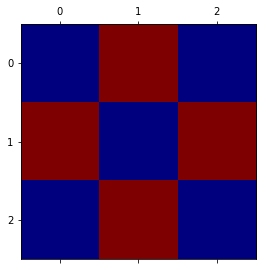

In [7]:
MyAxes.matshow(MyGrid['Value']); MyFigure

Now we update and show the grid.

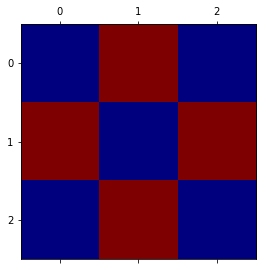

In [8]:
MyGrid.Update(); MyAxes.matshow(MyGrid['Value']); MyFigure

We will update and show the grid one more time.  The grid is in a steady state as it should as each 'alive' cell has exactly two neighbors that are also 'alive,' and each 'dead' neighbor is surrounded by four 'alive' neighbors so it always stays 'dead.'

In [9]:
MyGrid.Update(); print(MyGrid['State']); print(MyGrid['Value'])

[[False  True False]
 [ True False  True]
 [False  True False]]
[[ 0.  1.  0.]
 [ 1.  0.  1.]
 [ 0.  1.  0.]]


<h2>Continuous Line</h2>
<p>With periodic boundary conditions, a continuous line grows and then dies because of overpopulation.</p>

In [10]:
rows = 3; columns = 3; MyGrid=CAGrid((rows,columns),MyDtype)
setstates(MyGrid, rows, columns, (0,0,0,1,1,1,0,0,0))
print(MyGrid['Value'])

[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]]


In [11]:
MyGrid.Update(); print(MyGrid['Value'])

[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


In [12]:
MyGrid.Update(); print(MyGrid['Value'])

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


<h2>Blinker</h2>
<p>If we surround the line with empty cells, it is a <a href = http://web.stanford.edu/~cdebs/GameOfLife/ >blinker</a>.</p>

In [13]:
rows = 4; columns = 4; MyGrid=CAGrid((rows,columns),MyDtype);
setstates(MyGrid, rows, columns, (0,0,0,0, 0,1,1,1, 0,0,0,0, 0,0,0,0));
print(MyGrid['Value'])

[[ 0.  0.  0.  0.]
 [ 0.  1.  1.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [14]:
MyGrid.Update(); print(MyGrid['Value'])

[[ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]


In [15]:
MyGrid.Update(); print(MyGrid['Value'])

[[ 0.  0.  0.  0.]
 [ 0.  1.  1.  1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [16]:
MyGrid.Update(); print(MyGrid['Value'])

[[ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]


## Small Grid Animation Test
We will now run a small simulation to demonstrate this game of life simulation.  The final result of this test is an animation of the simulation.  Matplotlib has a built in [animation module](http://matplotlib.org/api/animation_api.html).  [This notebook](https://github.com/WillClaudeHolmes/Jupyter_Examples/blob/master/AnimationIllustration.ipynb) describes the necessary background as well well as gives several examples.

The matplotlib [function animation method](http://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation) requires a callable function which updates the figure.  This function must take one argument, the sequence number of the image being produced.  The `af(n)` function defined below is this function for this simulation.

In the cells below, we will save the animation to an external file, and then include it in the notebook with the [html video tag](https://www.w3schools.com/tags/tag_video.asp).

In [17]:
def af(n):
    MyGrid.Update()
    MyAxes.matshow(MyGrid['Value'])

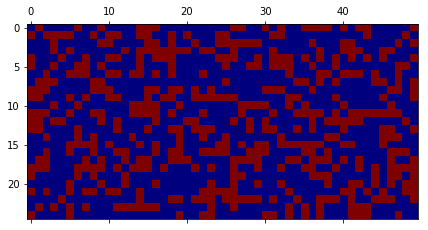

In [18]:
rows = 25; columns = 50;
MyGrid=CAGrid((rows,columns),MyDtype)  #initilized with whatever random memory was at the location.
setrandomstate(MyGrid,38)              #set 38% (3/8) cells as 'alive.'  
MyGrid.FinishUpdate()
MyAxes.matshow(MyGrid['State'])
MyFigure

In [19]:
AnimationFrames = 400  #total number of frames in animation.
DelayBetweenFrames = 33 #in msec (20 gives 50 fps) (33.3 gives 30 fps)
AnimationTime = AnimationFrames * DelayBetweenFrames/1000
print ("The animation will be {:.1f} seconds long.".format(AnimationTime))

The animation will be 13.2 seconds long.


In [20]:
MyAnimation = animation.FuncAnimation(MyFigure, af,
                               frames=AnimationFrames, interval=DelayBetweenFrames, blit=False)
MyAnimation.save('GOL_Small_Grid_test.mp4',extra_args=['-vcodec', 'h264'])

<video controls autoplay loop src="GOL_Small_Grid_test.mp4" />

<h2>Glider Tests</h2>
<p>A good test for the game of life simulation is if a <a href = http://web.stanford.edu/~cdebs/GameOfLife/ >glider</a> will act correctly.
<h3>Small Grid Example</h3>

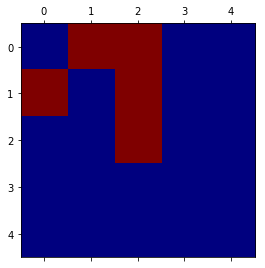

In [21]:
rows = 5; columns = 5
MyGrid=CAGrid((rows,columns),MyDtype)
#Set all values to zero or 'dead' or False
numpy.copyto(MyGrid['State'],numpy.zeros((rows,columns),dtype=numpy.dtype(bool)))
#Set specific cells to 'alive' or True
MyGrid['State'][0][1] = True
MyGrid['State'][1][1] = True
MyGrid['State'][1][2] = True
MyGrid['State'][2][0] = True
MyGrid['State'][2][2] = True

MyGrid.FinishUpdate()
MyAxes.matshow(MyGrid['State'])
MyFigure

In [22]:
AnimationFrames = 20  #total number of frames in animation.
DelayBetweenFrames = 1000 #in msec (20 gives 50 fps) (33.3 gives 30 fps)
AnimationTime = AnimationFrames * DelayBetweenFrames/1000
print ("The animation will be {:.1f} seconds long.".format(AnimationTime))

The animation will be 20.0 seconds long.


In [23]:
MyAnimation = animation.FuncAnimation(MyFigure, af,
                               frames=AnimationFrames, interval=DelayBetweenFrames, blit=False)
MyAnimation.save('GOL_Glider_test.mp4',extra_args=['-vcodec', 'h264'])

<video controls autoplay loop src="GOL_Glider_test.mp4" />

It does indeed return to its initial state.

### Large Grid Glider Test with Multiple Gliders
Let us put several gliders onto the same grid and let them run.  When they collide they produce different patterns.

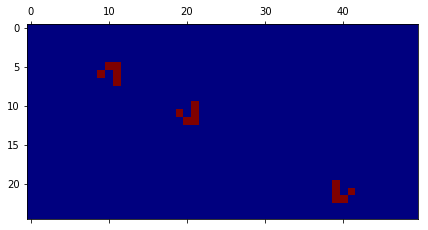

In [24]:
rows = 25; columns = 50
MyGrid=CAGrid((rows,columns),MyDtype)
numpy.copyto(MyGrid['State'],numpy.zeros((rows,columns),dtype=numpy.dtype(bool)))
MyGrid['State'][5][10] = True
MyGrid['State'][6][10] = True
MyGrid['State'][6][11] = True
MyGrid['State'][7][9]  = True
MyGrid['State'][7][11] = True

MyGrid['State'][12][20] = True
MyGrid['State'][11][20] = True
MyGrid['State'][11][21] = True
MyGrid['State'][10][19] = True
MyGrid['State'][10][21] = True

MyGrid['State'][22][40] = True
MyGrid['State'][21][40] = True
MyGrid['State'][21][39] = True
MyGrid['State'][20][41] = True
MyGrid['State'][20][39] = True


MyGrid.FinishUpdate()
MyAxes.matshow(MyGrid['Value'])
MyFigure

In [25]:
AnimationFrames = 300  #total number of frames in animation.
DelayBetweenFrames = 100 #in msec (20 gives 50 fps) (33.3 gives 30 fps)
AnimationTime = AnimationFrames * DelayBetweenFrames/1000
print ("The animation will be {:.1f} seconds long.".format(AnimationTime))

The animation will be 30.0 seconds long.


In [26]:
MyAnimation = animation.FuncAnimation(MyFigure, af,
                               frames=AnimationFrames, interval=DelayBetweenFrames, blit=False)
MyAnimation.save('GOL_Glider_M_test.mp4',extra_args=['-vcodec', 'h264'])

The multiple glider example is below.
<video controls autoplay loop src="GOL_Glider_M_test.mp4" />

## Full Game of Life Simulation
Just for fun, let us run a simulation on a large grid.

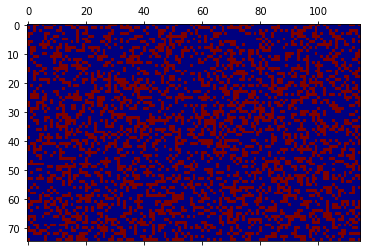

In [27]:
rows = 75
columns = 115
MyGrid=CAGrid((rows,columns),MyDtype)  #initilized with whatever random memory was at the location.
setrandomstate(MyGrid,38)
MyGrid.FinishUpdate()
MyFigure, MyAxes = plt.subplots()
MyAxes.matshow(MyGrid['State'])

In [28]:
AnimationFrames = 1000  #total number of frames in animation.
DelayBetweenFrames = 33 #in msec (20 gives 50 fps) (33.3 gives 30 fps)
AnimationTime = AnimationFrames * DelayBetweenFrames/1000
print ("The animation will be {:.1f} seconds long.".format(AnimationTime))

The animation will be 33.0 seconds long.


In [29]:
MyAnimation = animation.FuncAnimation(MyFigure, af,
                               frames=AnimationFrames, interval=DelayBetweenFrames, blit=False)
MyAnimation.save('GOL_Large_Sim.mp4',extra_args=['-vcodec', 'h264'])

<video controls autoplay loop src="GOL_Large_Sim.mp4" />